# Q-learning algorithm

In [3]:
import numpy as np
from gym.envs.toy_text import discrete
from collections import defaultdict
import time
import pickle
import os

from collections import namedtuple
import matplotlib.pyplot as plt

from gym.envs.classic_control import rendering

CELL_SIZE = 100
MARGIN = 10


def get_coords(row, col, loc='center'):
    xc = (col + 1.5) * CELL_SIZE
    yc = (row + 1.5) * CELL_SIZE
    if loc == 'center':
        return xc, yc
    elif loc == 'interior_corners':
        half_size = CELL_SIZE//2 - MARGIN
        xl, xr = xc - half_size, xc + half_size
        yt, yb = xc - half_size, xc + half_size
        return [(xl, yt), (xr, yt), (xr, yb), (xl, yb)]
    elif loc == 'interior_triangle':
        x1, y1 = xc, yc + CELL_SIZE//3
        x2, y2 = xc + CELL_SIZE//3, yc - CELL_SIZE//3
        x3, y3 = xc - CELL_SIZE//3, yc - CELL_SIZE//3
        return [(x1, y1), (x2, y2), (x3, y3)]


def draw_object(coords_list):
    if len(coords_list) == 1:  # -> circle
        obj = rendering.make_circle(int(0.45*CELL_SIZE))
        obj_transform = rendering.Transform()
        obj.add_attr(obj_transform)
        obj_transform.set_translation(*coords_list[0])
        obj.set_color(0.2, 0.2, 0.2)  # -> black
    elif len(coords_list) == 3:  # -> triangle
        obj = rendering.FilledPolygon(coords_list)
        obj.set_color(0.9, 0.6, 0.2)  # -> yellow
    elif len(coords_list) > 3:  # -> polygon
        obj = rendering.FilledPolygon(coords_list)
        obj.set_color(0.4, 0.4, 0.8)  # -> blue
    return obj


class GridWorldEnv(discrete.DiscreteEnv):
    def __init__(self, num_rows=4, num_cols=6, delay=0.05):
        self.num_rows = num_rows
        self.num_cols = num_cols

        self.delay = delay

        move_up = lambda row, col: (max(row - 1, 0), col)
        move_down = lambda row, col: (min(row + 1, num_rows - 1), col)
        move_left = lambda row, col: (row, max(col - 1, 0))
        move_right = lambda row, col: (row, min(col + 1, num_cols - 1))

        self.action_defs = {0: move_up, 1: move_right,
                            2: move_down, 3: move_left}

        # Number of states/actions
        nS = num_cols * num_rows
        nA = len(self.action_defs)
        self.grid2state_dict = {(s // num_cols, s % num_cols): s
                                for s in range(nS)}
        self.state2grid_dict = {s: (s // num_cols, s % num_cols)
                                for s in range(nS)}

        # Gold state
        gold_cell = (num_rows // 2, num_cols - 2)

        # Trap states
        trap_cells = [((gold_cell[0] + 1), gold_cell[1]),
                      (gold_cell[0], gold_cell[1] - 1),
                      ((gold_cell[0] - 1), gold_cell[1])]

        gold_state = self.grid2state_dict[gold_cell]
        trap_states = [self.grid2state_dict[(r, c)]
                       for (r, c) in trap_cells]
        self.terminal_states = [gold_state] + trap_states
        print(self.terminal_states)

        # Build the transition probability
        P = defaultdict(dict)
        for s in range(nS):
            row, col = self.state2grid_dict[s]
            P[s] = defaultdict(list)
            for a in range(nA):
                action = self.action_defs[a]
                next_s = self.grid2state_dict[action(row, col)]

                # Terminal state
                if self.is_terminal(next_s):
                    r = (1.0 if next_s == self.terminal_states[0]
                         else -1.0)
                else:
                    r = 0.0
                if self.is_terminal(s):
                    done = True
                    next_s = s
                else:
                    done = False
                P[s][a] = [(1.0, next_s, r, done)]

        # Initial state distribution
        isd = np.zeros(nS)
        isd[0] = 1.0

        super(GridWorldEnv, self).__init__(nS, nA, P, isd)

        self.viewer = None
        self._build_display(gold_cell, trap_cells)

    def is_terminal(self, state):
        return state in self.terminal_states

    def _build_display(self, gold_cell, trap_cells):

        screen_width = (self.num_cols + 2) * CELL_SIZE
        screen_height = (self.num_rows + 2) * CELL_SIZE
        self.viewer = rendering.Viewer(screen_width,
                                       screen_height)

        all_objects = []

        # List of border points' coordinates
        bp_list = [
            (CELL_SIZE - MARGIN, CELL_SIZE - MARGIN),
            (screen_width - CELL_SIZE + MARGIN, CELL_SIZE - MARGIN),
            (screen_width - CELL_SIZE + MARGIN,
             screen_height - CELL_SIZE + MARGIN),
            (CELL_SIZE - MARGIN, screen_height - CELL_SIZE + MARGIN)
        ]
        border = rendering.PolyLine(bp_list, True)
        border.set_linewidth(5)
        all_objects.append(border)

        # Vertical lines
        for col in range(self.num_cols + 1):
            x1, y1 = (col + 1) * CELL_SIZE, CELL_SIZE
            x2, y2 = (col + 1) * CELL_SIZE, \
                     (self.num_rows + 1) * CELL_SIZE
            line = rendering.PolyLine([(x1, y1), (x2, y2)], False)
            all_objects.append(line)

        # Horizontal lines
        for row in range(self.num_rows + 1):
            x1, y1 = CELL_SIZE, (row + 1) * CELL_SIZE
            x2, y2 = (self.num_cols + 1) * CELL_SIZE, \
                     (row + 1) * CELL_SIZE
            line = rendering.PolyLine([(x1, y1), (x2, y2)], False)
            all_objects.append(line)

        # Traps: --> circles
        for cell in trap_cells:
            trap_coords = get_coords(*cell, loc='center')
            all_objects.append(draw_object([trap_coords]))

        # Gold:  --> triangle
        gold_coords = get_coords(*gold_cell,
                                 loc='interior_triangle')
        all_objects.append(draw_object(gold_coords))

        # Agent --> square or robot
        if (os.path.exists('robot-coordinates.pkl') and CELL_SIZE == 100):
            agent_coords = pickle.load(
                open('robot-coordinates.pkl', 'rb'))
            starting_coords = get_coords(0, 0, loc='center')
            agent_coords += np.array(starting_coords)
        else:
            agent_coords = get_coords(0, 0, loc='interior_corners')
        agent = draw_object(agent_coords)
        self.agent_trans = rendering.Transform()
        agent.add_attr(self.agent_trans)
        all_objects.append(agent)

        for obj in all_objects:
            self.viewer.add_geom(obj)

    def render(self, mode='human', done=False):
        if done:
            sleep_time = 1
        else:
            sleep_time = self.delay
        x_coord = self.s % self.num_cols
        y_coord = self.s // self.num_cols
        x_coord = (x_coord + 0) * CELL_SIZE
        y_coord = (y_coord + 0) * CELL_SIZE
        self.agent_trans.set_translation(x_coord, y_coord)
        rend = self.viewer.render(
            return_rgb_array=(mode == 'rgb_array'))
        time.sleep(sleep_time)
        return rend

    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None


if __name__ == '__main__':
    env = GridWorldEnv(5, 6)
    for i in range(1):
        s = env.reset()
        env.render(mode='human', done=False)

        while True:
            action = np.random.choice(env.nA)
            res = env.step(action)
            print('Action ', env.s, action, ' -> ', res)
            env.render(mode='human', done=res[2])
            if res[2]:
                break

    env.close()



[16, 22, 15, 10]
Action  6 2  ->  (6, 0.0, False, {'prob': 1.0})
Action  0 0  ->  (0, 0.0, False, {'prob': 1.0})
Action  1 1  ->  (1, 0.0, False, {'prob': 1.0})
Action  2 1  ->  (2, 0.0, False, {'prob': 1.0})
Action  8 2  ->  (8, 0.0, False, {'prob': 1.0})
Action  2 0  ->  (2, 0.0, False, {'prob': 1.0})
Action  1 3  ->  (1, 0.0, False, {'prob': 1.0})
Action  7 2  ->  (7, 0.0, False, {'prob': 1.0})
Action  8 1  ->  (8, 0.0, False, {'prob': 1.0})
Action  2 0  ->  (2, 0.0, False, {'prob': 1.0})
Action  8 2  ->  (8, 0.0, False, {'prob': 1.0})
Action  2 0  ->  (2, 0.0, False, {'prob': 1.0})
Action  8 2  ->  (8, 0.0, False, {'prob': 1.0})
Action  9 1  ->  (9, 0.0, False, {'prob': 1.0})
Action  10 1  ->  (10, -1.0, False, {'prob': 1.0})
Action  10 0  ->  (10, 0.0, True, {'prob': 1.0})


In [4]:
class Agent(object):
    def __init__(
            self, env,
            learning_rate=0.01,
            discount_factor=0.9,
            epsilon_greedy=0.9,
            epsilon_min=0.1,
            epsilon_decay=0.95):
        self.env = env
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon_greedy
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        # Define the q_table
        self.q_table = defaultdict(lambda: np.zeros(self.env.nA))

    def choose_action(self, state):
        if np.random.uniform() < self.epsilon:
            action = np.random.choice(self.env.nA)
        else:
            q_vals = self.q_table[state]
            perm_actions = np.random.permutation(self.env.nA)
            q_vals = [q_vals[a] for a in perm_actions]
            perm_q_argmax = np.argmax(q_vals)
            action = perm_actions[perm_q_argmax]
        return action

    def _learn(self, transition):
        s, a, r, next_s, done = transition
        q_val = self.q_table[s][a]
        if done:
            q_target = r
        else:
            q_target = r + self.gamma*np.max(self.q_table[next_s])

        # Update the q_table
        self.q_table[s][a] += self.lr * (q_target - q_val)

        # Adjust the epislon
        self._adjust_epsilon()

    def _adjust_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay



[16, 22, 15, 10]
Episode 0: Reward -1.0 #Moves 10
Episode 1: Reward -1.0 #Moves 40
Episode 2: Reward -1.0 #Moves 28
Episode 3: Reward -1.0 #Moves 21
Episode 4: Reward -1.0 #Moves 20
Episode 5: Reward -1.0 #Moves 22
Episode 6: Reward -1.0 #Moves 39
Episode 7: Reward 1.0 #Moves 42
Episode 8: Reward -1.0 #Moves 145
Episode 9: Reward -1.0 #Moves 47
Episode 10: Reward -1.0 #Moves 9
Episode 11: Reward -1.0 #Moves 133
Episode 12: Reward 1.0 #Moves 45
Episode 13: Reward 1.0 #Moves 264
Episode 14: Reward -1.0 #Moves 47
Episode 15: Reward 1.0 #Moves 32
Episode 16: Reward -1.0 #Moves 321
Episode 17: Reward 1.0 #Moves 18
Episode 18: Reward 1.0 #Moves 24
Episode 19: Reward 1.0 #Moves 50
Episode 20: Reward 1.0 #Moves 91
Episode 21: Reward 1.0 #Moves 17
Episode 22: Reward 1.0 #Moves 51
Episode 23: Reward 1.0 #Moves 14
Episode 24: Reward 1.0 #Moves 20
Episode 25: Reward 1.0 #Moves 13
Episode 26: Reward 1.0 #Moves 11
Episode 27: Reward 1.0 #Moves 11
Episode 28: Reward 1.0 #Moves 11
Episode 29: Reward 1

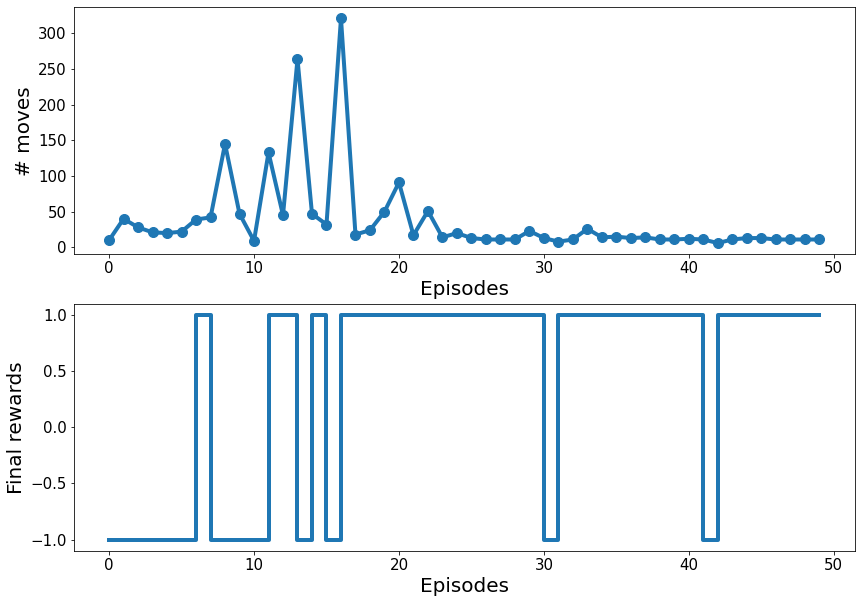

In [5]:
np.random.seed(1)

Transition = namedtuple(
    'Transition', ('state', 'action', 'reward', 'next_state', 'done'))


def run_qlearning(agent, env, num_episodes=50):
    history = []
    for episode in range(num_episodes):
        state = env.reset()
        env.render(mode='human')
        final_reward, n_moves = 0.0, 0
        while True:
            action = agent.choose_action(state)
            next_s, reward, done, _ = env.step(action)
            agent._learn(Transition(state, action, reward,
                                    next_s, done))
            env.render(mode='human', done=done)
            state = next_s
            n_moves += 1
            if done:
                break
            final_reward = reward
        history.append((n_moves, final_reward))
        print('Episode %d: Reward %.1f #Moves %d'
              % (episode, final_reward, n_moves))

    return history


def plot_learning_history(history):
    fig = plt.figure(1, figsize=(14, 10))
    ax = fig.add_subplot(2, 1, 1)
    episodes = np.arange(len(history))
    moves = np.array([h[0] for h in history])
    plt.plot(episodes, moves, lw=4,
             marker="o", markersize=10)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.xlabel('Episodes', size=20)
    plt.ylabel('# moves', size=20)

    ax = fig.add_subplot(2, 1, 2)
    rewards = np.array([h[1] for h in history])
    plt.step(episodes, rewards, lw=4)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.xlabel('Episodes', size=20)
    plt.ylabel('Final rewards', size=20)
    plt.savefig('q-learning-history.png', dpi=300)
    plt.show()


if __name__ == '__main__':
    env = GridWorldEnv(num_rows=5, num_cols=6)
    agent = Agent(env)
    history = run_qlearning(agent, env)
    env.close()

    plot_learning_history(history)
